# 図の作成例

CSVファイルの波形記録を読み取って描画するサンプルノートブック．  
他のフォルダには移動させないようにしてください．

|Date      |Commit history|
|:---------|:-------------|
|04/28 2021|First created by Yasunori Sawaki (Kyoto Univ.)|
|05/16     |Interactive plot using [`Bokeh`](https://bokeh.org/)|
|05/24     |Add an example plot with true time axis|
|06/09     |Correct small mistakes|
|04/18 2023|Set the directory path as default|
|05/04     |Set the default python version as 3.8|
|04/08 2024|Simplified several code|
|04/16      |Add spectrogram|

To run each cell, only to enter `Shift+Enter` (cf. `Ctrl+Enter`)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 必要なパッケージのインポート&パス設定

1.Pythonでは，パッケージを`import`することで使用可能になる

2.下のセルを実行，パスを'/content/drive/MyDrive/EarthScienceExperiment'に設定(Default)  

2.Run next cell and set path to `default` value ('/content/drive/MyDrive/EarthScienceExperiment')

In [2]:
import sys
import os
from pathlib import Path
from datetime import datetime, timedelta
from datetime import time as dtime
import argparse
import requests
import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.dates as mdates
import pandas as pd
from scipy import signal
import scipy

# For interactive plot
import bokeh.plotting as blt
import bokeh.models as bmd
from bokeh.layouts import layout

# Set current file name
notebookname = 'PlotCSV.ipynb'

# Set directory path
projectBaseDir = "/content/drive/MyDrive/EarthScienceExperiment" #@param ["/content/drive/MyDrive/EarthScienceExperiment"] {allow-input: false}
projectBaseDir = Path(projectBaseDir)

if not os.path.exists(projectBaseDir/notebookname):
    raise FileNotFoundError(f'Path not found. Check again projectBaseDir: {projectBaseDir}')

print(f'Found "{projectBaseDir}"')
os.chdir(projectBaseDir)

Found "/content/drive/MyDrive/EarthScienceExperiment"


### 描画パッケージ`matplotlib`のおまじない

In [3]:
# @markdown `plt.rcParams (matplotlib resource configurations)`の設定
# @markdown <u>このセルも実行</u>してください

plt.rc('figure', figsize=[8,6], facecolor='w', dpi=100, )

## savefig
plt.rc(
    'savefig', format='png',
    dpi=plt.rcParams['figure.dpi'],
    edgecolor=plt.rcParams['figure.edgecolor'],
    facecolor=plt.rcParams['figure.facecolor'],
    bbox='tight', transparent=False,
)
plt.rc('font', family='sans-serif', size='12')

plt.rc('axes', grid=True, linewidth=1.0, axisbelow=True)
plt.rc('axes.grid', axis='both')

plt.rc('lines', linestyle='-', linewidth=0.4)

plt.rc('grid', linewidth=0.5, linestyle='--', alpha=0.8)

plt.rc('xtick', direction='in', bottom=True, top=True, labelsize=12)
plt.rc('xtick.major', width=1.0, size=5)
plt.rc('xtick.minor', visible=True, size=2.5)
plt.rc('ytick', direction='in', left=True, right=True, labelsize=12)
plt.rc('ytick.major', width=1.0, size=5)
plt.rc('ytick.minor', visible=True, size=2.5)

plt.rc(
    'legend', markerscale=1,
    frameon=True, fancybox=False, framealpha=1, #edgecolor='k'
)

# #@markdown - 作図で日本語を使う場合は`use_japanise`をチェックして実行
# use_japanise = True #@param {type:"boolean"}

# if use_japanise:
#     !pip install japanize-matplotlib -q
#     import japanize_matplotlib
# else:
#     if "japanize_matplotlib" in sys.modules:
#         print(
#             '日本語設定を止める場合は，「ランタイムを再起動」し，'
#             '「必要なパッケージのインポート」からやり直してください'
#         )

## CSVファイルの読み込み

- `taxis`: 時間軸の`ndarray`
- `wavdata`: 各チャンネルのデータ`ndarray`
- `wavtime`: 時刻の`ndarray`

In [4]:
# @markdown CSVファイルのパスを記述 {run: "auto"}
filepath = "./output/20240430_all_100Hz.csv" #@param ["./output/20230418_all_100Hz.csv", "./output/20230418_all_10Hz.csv"] {allow-input: true}
filepath = Path(filepath)

# Extract `starttime`
with filepath.open('r') as f:
    f.readline()
    starttime = datetime.strptime(
        f.readline().split()[-1],
        '%Y-%m-%dT%H:%M:%S.%fZ'
    )

print('starttime: ', starttime)

df = pd.read_csv(
    filepath,
    comment='#',
    names=('Time','Ch1','Ch2','Ch3','Ch4')
)

taxis, *wavdata = df.to_numpy().T
wavtime = pd.date_range(
    start=starttime, periods=len(df),
    freq=f"{int(1000*(taxis[1]-taxis[0]))}ms"
)

clapperboard_time=None

df

starttime:  2024-04-30 14:08:08


,Time,Ch1,Ch2,Ch3,Ch4
0,0.00,-5094.104914,-457.181810,-2941.299429,-1166.102971
1,0.01,-5195.154535,-467.326469,-2998.077169,-1187.491430
2,0.02,-5115.962495,-453.002375,-2929.178948,-1164.995423
3,0.03,-5191.004959,-472.886394,-3010.005414,-1159.645853
4,0.04,-5102.684923,-438.849965,-2937.694780,-1134.528241
...,...,...,...,...,...
674495,6744.95,542.381309,12130.193296,2728.182878,-9193.716983
674496,6744.96,-2886.239736,12407.128251,4117.836885,2460.720927
674497,6744.97,-4287.811900,2817.336061,1737.478882,8747.432413
674498,6744.98,-2416.564804,-8264.620710,-5015.809162,11275.820865


In [10]:
# @title カチンコによる収録開始時刻

clapperboard_time = "15:23:16.170000" #@param ["None", "\"14:52:23.000000\""] {type:"raw", allow-input: true}
if clapperboard_time:
    clapperboard_time = dtime.fromisoformat(clapperboard_time)

## プロット例

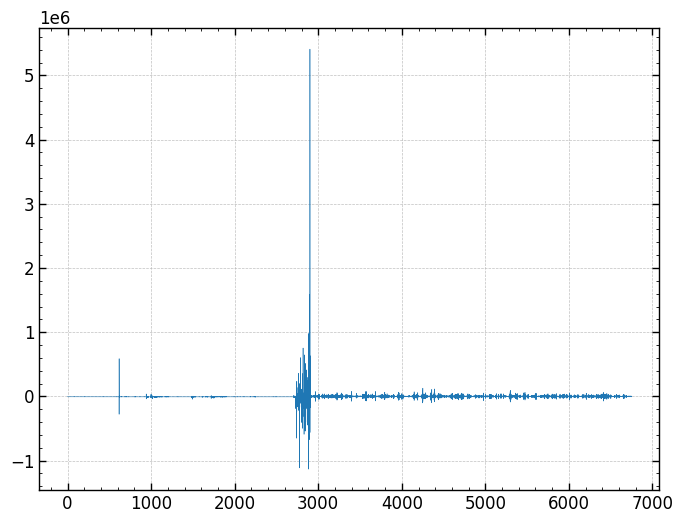

In [7]:
plt.plot(taxis, wavdata[0]);

In [9]:
# @title Interactive plot with true time axis

# @markdown - `offset`と縦軸範囲`ylim`を設定
offset = 100000 #@param
ylim = (-200000, 300000) #@param ["None", "(-100000, 200000)"] {type:"raw", allow-input: true}

# @markdown - `decimate`: データの間引き
# @markdown   - `decimate=1`: 間引きなし
# @markdown   - `decimate=10`: `1/10`に間引き
decimate = 10 #@param {type:"slider", min:1, max:20, step:1}

fig = blt.figure(
    title=f"Interactive plot with true time axis on {starttime.date().strftime('%Y/%m/%d')}",
    x_axis_label='Time', y_axis_label='Amplitude [nm/s]',
    x_range=(starttime, starttime+timedelta(hours=1)), y_range=ylim,
    width=800, height=500, toolbar_location="above",
    x_axis_type="datetime",
)

for ich, data_i in enumerate(wavdata):
    fig.line(
        wavtime[::decimate], data_i[::decimate]+offset*(ich-1),
        legend_label=f"Ch{ich+1}", line_width=1., line_alpha=0.3,
        line_color=('blue','orange','green','red')[ich]
    )

xslider = bmd.DateRangeSlider(
    title="Adjust x-axis range",
    start=wavtime[0], end=wavtime[-1], #step=10,
    value=(wavtime[0], wavtime[-1]),  # initial values for slider
)
xslider.js_link("value", fig.x_range, "start", attr_selector=0)
xslider.js_link("value", fig.x_range, "end", attr_selector=1)

## create layout
lay = layout([
    [xslider],
    [fig],
])

## show result
# blt.output_file(filepath.name.replace('csv','html'), title=filepath.name.strip('.csv'))
blt.output_notebook()
blt.show(lay)

Output hidden; open in https://colab.research.google.com to view.

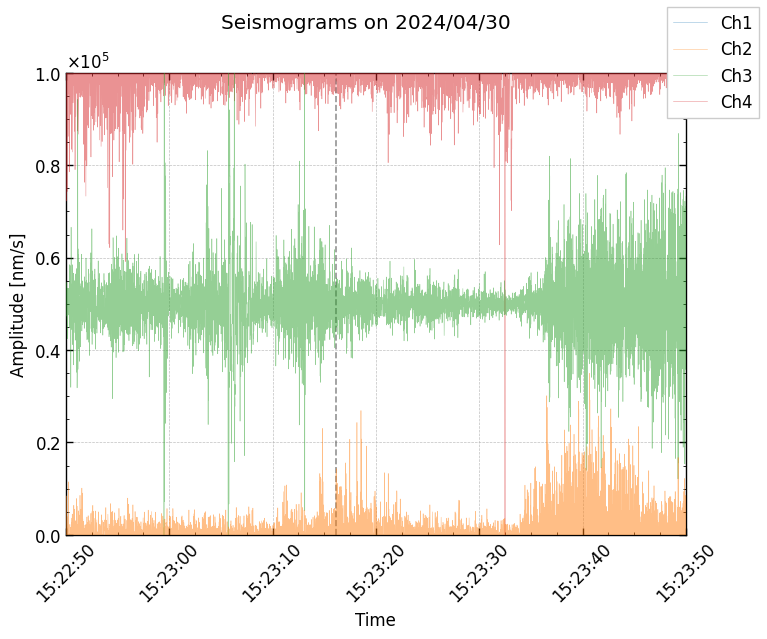

In [13]:
# @title 図の作成例

fig, ax = plt.subplots()

# カチンコ時刻
if clapperboard_time:
    ax.axvline(
        x=datetime.combine(starttime.date(), clapperboard_time),
        c='0.3', lw=1.2, ls='dashed', alpha=0.6
    )

# @markdown - `offset`と線の太さを設定
offset = 5*10**4 #@param
linewidth = 0.4 #@param {type:"slider", min:0.2, max:3, step:0.1, default:0.4}

for ich, data_i in enumerate(wavdata):
    ax.plot(
        wavtime, data_i+offset*(ich-1),
        lw=linewidth,
        alpha=0.5, label=f'Ch{ich+1}', zorder=3-0.1*ich,
    )

# @markdown - 時刻のフォーマット設定
time_format = "%H:%M:%S" #@param ["%H:%M", "%H:%M:%S", "%H:%M:%S\n.%f"] {allow-input: true}
xlabel_rotation = 45 #@param {type:"slider", min:0, max:90, step:15}
ax.xaxis.set_major_formatter(mdates.DateFormatter(time_format))
ax.xaxis.set_tick_params(rotation=xlabel_rotation)

# @markdown - `xlim`と`ylim`を設定
xlim = ("15:22:50", "15:23:50") #@param ["None", "(\"14:45\", \"15:05\")"] {type:"raw", allow-input: true}
ylim = (00000, 100000) #@param ["None", "(-100000, 200000)"] {type:"raw", allow-input: true}
if xlim:
    xlim = map(
        lambda x: datetime.combine(starttime.date(), dtime.fromisoformat(x)),
        xlim
    )

ax.set(
    xlim=xlim, ylim=ylim,
    xlabel=('Time'),
    ylabel=('Amplitude [nm/s]')
)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

## Legend
fig.legend()
## Title
fig_title = "Seismograms" #@param ["", "Seismograms"] {allow-input: true}
if fig_title:
    fig.suptitle(fig_title+f" on {starttime.date().strftime('%Y/%m/%d')}")

plt.show()

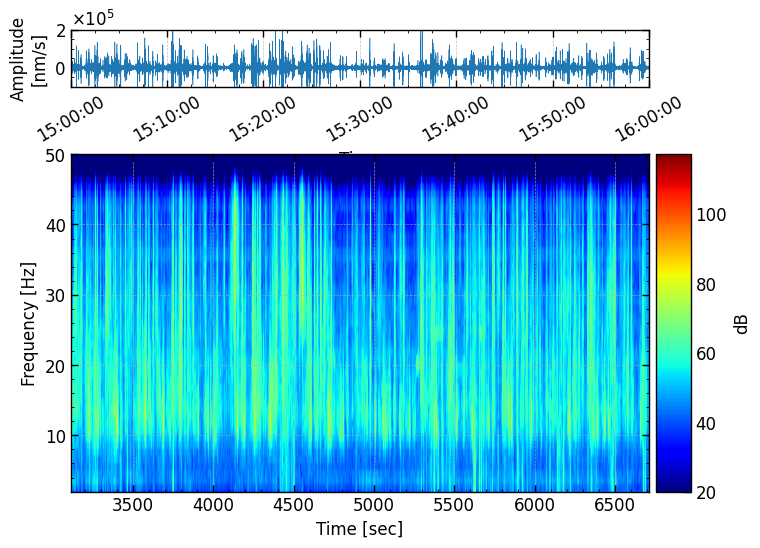

In [18]:
# @title スペクトログラム(Spectrogram)の作成
fig = plt.figure()
ax1 = plt.subplot2grid((15,15),(0,0),colspan=14,rowspan=2,fig=fig)
ax2 = plt.subplot2grid((15,15),(4,0),colspan=14,rowspan=11,fig=fig)
ax3 = plt.subplot2grid((15,15),(4,14),colspan=1,rowspan=11,fig=fig)
# @markdown - チャンネル選択
channel = 3 #@param [1, 2, 3, 4] {type:"raw"}
# @markdown - `decimate`: データの間引き
decimate = 1 #@param {type:"slider", min:1, max:20, step:1}
wav=wavdata[channel-1][::decimate]
wavtime_tem=wavtime[::decimate]
fs=int(100/decimate)

# @markdown - 図1線の太さを設定
linewidth = 0.4 #@param {type:"slider", min:0.2, max:3, step:0.1, default:0.4}

# @markdown - 時刻のフォーマット設定
time_format = "%H:%M:%S" #@param ["%H:%M", "%H:%M:%S", "%H:%M:%S\n.%f"] {allow-input: true}
xlabel_rotation = 30 #@param {type:"slider", min:0, max:90, step:15}

# @markdown - `xlim`と`ylim`を設定
xlim = ("15:00:00", "16:00:00") #@param ["None", "(\"14:45\", \"15:05\")"] {type:"raw", allow-input: true}
ylim = (-100000, 200000) #@param ["None", "(-100000, 200000)"] {type:"raw", allow-input: true}
if xlim:
    xlim = map(
        lambda x: datetime.combine(starttime.date(), dtime.fromisoformat(x)),
        xlim
    )
xlim_2=copy.deepcopy(xlim)

ax1.plot(
        wavtime_tem, wav,
        lw=linewidth,
        label=f'Ch{channel}'
        )
ax1.set(
    xlim=xlim,
    ylim=ylim,
    xlabel=('Time'),
    ylabel=('Amplitude'+'\n'+'[nm/s]')
)
ax1.xaxis.set_major_formatter(mdates.DateFormatter(time_format))
ax1.xaxis.set_tick_params(rotation=xlabel_rotation)
ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))

if xlim_2:
    xlim_2 = map(
        lambda x: int(timedelta.total_seconds(x-starttime)),
        xlim_2
    )
# for xx in xlim_2:
#   print(xx)
cmap = plt.get_cmap('jet')
win_len = 104 #@param {type:"slider", min:8, max:512, step:8, default:64}
Pxx, freqs, times, cax = ax2.specgram(wav, NFFT=win_len, Fs=fs, noverlap=int(win_len/2), cmap=cmap,
                                      scale='dB', vmin=20)
Hzlim = (2, 50) #@param ["None", "(0, 20)"] {type:"raw", allow-input: true}
ax2.set(
    xlim=xlim_2,
    ylim=Hzlim,
    xlabel=('Time [sec]'),
    ylabel=('Frequency [Hz]')
)

cbar = plt.colorbar(cax, cax=ax3, ax=ax2)
ax3.set(
    ylabel=('dB')
)
plt.show()

In [ ]:
# @title 時刻と経過時間の換算

recorded = datetime.strptime(filepath.name[:8], '%Y%m%d')

t0 = str(clapperboard_time) #@param ["str(starttime.time())", "str(clapperboard_time)", "\"14:52:23\""] {type:"raw", allow-input: true}
t1 = "15:48:59" #@param ["None", "\"15:16:19\"", "str(clapperboard_time)"] {type:"raw", allow-input: true}

#@markdown - `starttime.time()`: 収録開始時刻
#@markdown - `clapperboard_time`: カチンコによる収録開始時刻（上のセルで指定が必要）

try:
    ans = datetime.combine(recorded, dtime.fromisoformat(t1)) \
    - datetime.combine(recorded, dtime.fromisoformat(t0))
except TypeError:
    ans = None
except ValueError:
    print('Invalid format or "None" found in `t0` or `t1`')
else:
    print('t1 - t0 =', int(ans.total_seconds()), '[s]')


## Tips

基本的な統計処理の方法を示します

In [ ]:
xx = np.linspace(0,10,1000)
yy = 0.4*xx + np.sin(4*xx) - 3 + 0.15*np.random.randn(1000)

plt.plot(xx, yy)

### 平均

- `np.average()`

In [ ]:
np.average(yy)

In [ ]:
np.average(wavdata[0])

### 線形トレンド除去

- [`signal.detrend()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html)

In [ ]:
zz = signal.detrend(yy)
plt.plot(xx, zz)

### 二乗振幅・絶対値振幅

- 二乗振幅：`zz_squared = zz ** 2`
- 絶対値振幅：`np.sqrt(zz_squared)` または `np.abs(zz)`

速度の二乗振幅はどういう物理量に対応…？

In [ ]:
zz_squared = zz ** 2
plt.plot(xx, zz_squared)

### 包絡線

`np.abs(signal.hilbert(zz))`

詳しくは，[`scipy.signal.hilbert`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)

In [ ]:
vv = np.abs(signal.hilbert(zz))
plt.plot(xx, zz)
plt.plot(xx, vv, lw=0.8, c='0.3')
plt.plot(xx, -vv, lw=0.8, c='0.3')

In [ ]:
np.max(abs(wavdata[0]))